In [2]:
import random
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Define constants
MIN_BET  = 0.5

# Black Jack Game Simulator

This study creates a module black jack simulator adaptable across any user-specified strategy. 

Currently supported and tested strategies include:
1) Simple, low-dimensional, rules-based strategies
2) Martingale double-down strategy with dynamic bet-sizing
3) Exponentially decayed martingale dynamic bet-sizing     

Future implementations include:
1) Game theory optimal basic strategy 
2) Basic strategy + user-specified deviations
3) Card counting dynamic bet sizing + game theory optimal basic strategy

The purpose of this simulator is to efficiently capture the conditional probability dynamics that black jack is notorious for. This allows for proper probabilistic estimations of a bettor's risk of ruin, win rate, variance, and many more descriptive statistics.

In [4]:
class Card:
    def __init__(self, rank, suit):
        self.rank = rank
        self.suit = suit

class Deck:
    def __init__(self, num_decks=1):
        self.cards = []
        self.num_decks = num_decks
        self.reset()

    def reset(self):
        ranks = ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K']
        suits = ['Spades', 'Hearts', 'Diamonds', 'Clubs']
        self.cards = [Card(rank, suit) for _ in range(self.num_decks) for suit in suits for rank in ranks]
        random.shuffle(self.cards)

    def draw_card(self):
        return self.cards.pop()

    def penetration_percentage(self):
        return len(self.cards) / (self.num_decks * 52)

class Hand:
    def __init__(self):
        self.cards = []

    def add_card(self, card):
        self.cards.append(card)

    def get_value(self):
        value = 0
        num_aces = 0

        for card in self.cards:
            if card.rank == 'A':
                value += 11
                num_aces += 1
            elif card.rank in ['K', 'Q', 'J']:
                value += 10
            else:
                value += int(card.rank)

        while value > 21 and num_aces > 0:
            value -= 10
            num_aces -= 1

        return value

class Player:
    def __init__(self, name, bankroll, bet_size=None):
        self.name = name
        self.hand = Hand()
        self.bet_size = bet_size
        self.bankroll = bankroll
        self.pnl_time_series = []
        self.win_loss_time_series = []
        self.blackjack_time_series = []
        self.bet_size_time_series = []
        self.consecutive_losses_time_series = []
        self.profit = 0

    def draw_initial_hand(self, deck):
        for _ in range(2):
            card = deck.draw_card()
            self.hand.add_card(card)

    def draw_card(self, deck):
        card = deck.draw_card()
        self.hand.add_card(card)

    def display_hand(self, show_all_cards=False):
        print(f"{self.name}'s hand:")
        for i, card in enumerate(self.hand.cards):
            if i == 0 and not show_all_cards:
                print("  [Hidden Card]")
            else:
                print(f"  {card.rank} of {card.suit}")
        print("")

    def make_move(self, deck, strategy):

        while self.hand.get_value() <= 21:
            
            move = strategy(self, self.hand)    

            if move == 'stand':
                break           
            if move == 'hit':
                self.draw_card(deck)
            if move == 'surrender':
                self.bet_size /= 2
                break
            if move == 'double':
                self.draw_card(deck)
                self.bankroll -= self.bet_size
                self.bet_size *= 2
                break

        return move

    def can_double(self):
        return len(self.hand.cards) == 2

    def can_split(self):
        return len(self.hand.cards) == 2 and self.hand.cards[0].rank == self.hand.cards[1].rank
    
    def can_surrender(self):
        return len(self.hand.cards) == 2

def new_round(player, dealer, deck, bet_size):

    # Update bet size & bankroll
    player.bet_size = bet_size
    # player.bankroll -= player.bet_size
    
    # New player and dealer hand
    player.hand = Hand()
    dealer.hand = Hand()

    # Draw initial two cards
    player.draw_initial_hand(deck)
    dealer.draw_initial_hand(deck)

    return

def play_round(player, dealer, deck, strategy):

    # Indicates player blackjack 
    blackjack: bool = 0
    # Indicating win/loss/push
    outcome: int    

    # Deploy player's strategy
    move = player.make_move(deck, strategy)
    
    # Update hand values
    player_score = player.hand.get_value()
    dealer_score = dealer.hand.get_value()

    # Handle player's move and outcome
    # If surrender
    if move == 'surrender': 
        # print("Player surrenders! Dealer wins.")
        outcome = -1 # Loss
        player.profit -= player.bet_size
        # player.bankroll += player.bet_size  
        player.bankroll -= player.bet_size
    # If player bust  
    elif player_score > 21: 
        # print("Player busts! Dealer wins.")
        outcome = -1 # Loss
        player.profit -= player.bet_size
        player.bankroll -= player.bet_size
    else:
        # Handle dealer hits
        while dealer.hand.get_value() < 17:
            dealer.draw_card(deck)
        # Update dealer score
        dealer_score = dealer.hand.get_value() 

        # If dealer bust
        if dealer_score > 21: 
            # print("Dealer busts! Player wins.")
            outcome = 1 # Win
            player.profit += player.bet_size
            # player.bankroll += player.bet_size * 2
            player.bankroll += player.bet_size

        # If push
        elif player_score == dealer_score: 
            # print("Push! It's a tie.")
            outcome = 0 # Push/Tie
            # player.bankroll += player.bet_size
        # Player has a blackjack
        elif player_score == 21 and len(player.hand.cards) == 2: 
            # print("Player has a blackjack! Player wins.")
            blackjack = 1
            outcome = 1
            # player.profit += player.bet_size + (1.5 * player.bet_size)
            # player.bankroll += player.bet_size + (1.5 * player.bet_size)
            player.profit += 1.5 * player.bet_size
            player.bankroll += 1.5 * player.bet_size
        # Player wins
        elif player_score > dealer_score:
            # print("Player wins!")
            outcome = 1
            player.profit += player.bet_size
            # player.bankroll += player.bet_size * 2
            player.bankroll += player.bet_size
        # Dealer wins
        else: 
            # print("Dealer wins.")
            outcome = -1
            player.profit -= player.bet_size
            player.bankroll -= player.bet_size
            

    # Update player time series data
    player.pnl_time_series.append(player.bankroll)
    player.win_loss_time_series.append(outcome)
    player.blackjack_time_series.append(blackjack)
    player.bet_size_time_series.append(player.bet_size)
    
    # Update player's consecutive losses 
    if outcome == -1:
        if len(player.consecutive_losses_time_series) > 0:
            player.consecutive_losses_time_series.append(player.consecutive_losses_time_series[-1] + 1)
        else:
            player.consecutive_losses_time_series.append(1)
    elif outcome == 1: 
        player.consecutive_losses_time_series.append(0)    

    # print("Player's hand value:", player_score)
    # print("Dealer's hand value:", dealer_score)
    # print("Player's bankroll:", player.bankroll)
    # print("")

    return

def simulate_game(strategy, num_decks=6, num_hands=1000, penetration_limit=0.25, initial_bankroll=1000, bet_size=10):
    
    # Create player & dealer
    player = Player("Player", initial_bankroll, bet_size)
    dealer = Player("Dealer", 0)
    
    total_hands_played = 0
    
    while total_hands_played < num_hands:
        
        deck = Deck(num_decks)

        while deck.penetration_percentage() > penetration_limit:        

            # Create new round
            new_round(player=player, dealer=dealer, deck=deck, bet_size=bet_size)

            # Play round
            play_round(player=player, dealer=dealer, deck=deck, strategy=strategy)           

            # Update counter
            total_hands_played += 1
            
            # If bankrupt, break sim
            ruin_bool = player.bankroll < 0
            if ruin_bool:
                break
        # If bankrupt, break sim
        if ruin_bool:
            break 
    
    
    # Capture sim data
    total_hands_won = player.win_loss_time_series.count(1)
    total_hands_lost = player.win_loss_time_series.count(-1)
    total_hands_pushed = player.win_loss_time_series.count(0)
    total_blackjacks = player.blackjack_time_series.count(1)

    print("Simulation over!")
    print("Total hands played:", total_hands_played)
    print("Hands won:", total_hands_won)
    print("Hands lost:", total_hands_lost)
    print("Hands pushed:", total_hands_pushed)
    print("Total BlackJacks", total_blackjacks)
    print("Player's final bankroll:", player.bankroll)
    print("Player's total profit:", player.profit)

    plt.plot(player.pnl_time_series)

    return player

# Define BJ Strategies

In [5]:
martingale_bet_dict = dict()
for i in range(0, 41):
    if i == 0:
        martingale_bet_dict[i] = MIN_BET
    else:
        martingale_bet_dict[i] = martingale_bet_dict[i-1] * 2

martingale_stop_loss_bet_dict = dict()
for i in range(0, 41):
    if i == 0 or i > 14:
        martingale_stop_loss_bet_dict[i] = MIN_BET
    else:
        martingale_stop_loss_bet_dict[i] = martingale_stop_loss_bet_dict[i-1] * 2

martingale_stop_loss_2_bet_dict = dict()
for i in range(0, 41):
    if i == 0 or i > 11:
        martingale_stop_loss_2_bet_dict[i] = MIN_BET
    else:
        martingale_stop_loss_2_bet_dict[i] = martingale_stop_loss_2_bet_dict[i-1] * 2

martingale_exp_decay_bet_dict = dict()
decay_factor = .2
for i in range(0, 41):
    martingale_exp_decay_bet_dict[i] = round(martingale_bet_dict[i] * (1-decay_factor)**i)

martingale_exp_decay_mixed_bet_dict = dict()
for i in range(0, 41):
    if i > 8:
        martingale_exp_decay_mixed_bet_dict[i] = round(martingale_bet_dict[i] * (1-decay_factor)**i)
    else:
        martingale_exp_decay_mixed_bet_dict[i] = martingale_bet_dict[i]

def martingale_strategy(player, hand):

    # Adjust bet size according to martingale double-down strategy
    if player.can_double() and len(player.win_loss_time_series) > 0:
        try:
            player.bet_size = martingale_bet_dict[player.consecutive_losses_time_series[-1]]
        except:
            player.bet_size = 0.5

    # Get value of hand
    value = hand.get_value()

    if value == 21:
        return 'stand' # Always stand with 21

    if (value == 11 or value == 10) and player.can_double():
        return 'hit'  # Always double down on 11 or less
    
    if value >= 16:
        return 'stand'  # Always stand on 17 or more

    return 'hit'  # Otherwise, always hit

def basic_strategy(player, hand):

    value = hand.get_value()

    if value == 21:
        return 'stand' # Always stand with 21

    if value <= 11 and player.can_double():
        return 'double'  # Always double down on 11 or less
    
    if value >= 17:
        return 'stand'  # Always stand on 17 or more    

    return 'hit'  # Otherwise, always hit

# Run Monte Carlo Simulation

Simulation over!
Total hands played: 964
Hands won: 363
Hands lost: 512
Hands pushed: 89
Total BlackJacks 26
Player's final bankroll: -75.0
Player's total profit: -4450.0
Simulation over!
Total hands played: 1033
Hands won: 412
Hands lost: 516
Hands pushed: 105
Total BlackJacks 24
Player's final bankroll: 1275.0
Player's total profit: -2900.0
Simulation over!
Total hands played: 1036
Hands won: 431
Hands lost: 513
Hands pushed: 92
Total BlackJacks 23
Player's final bankroll: 1787.5
Player's total profit: -2237.5
Simulation over!
Total hands played: 1032
Hands won: 405
Hands lost: 529
Hands pushed: 98
Total BlackJacks 21
Player's final bankroll: 437.5
Player's total profit: -3362.5
Simulation over!
Total hands played: 1029
Hands won: 398
Hands lost: 520
Hands pushed: 111
Total BlackJacks 27
Player's final bankroll: 1612.5
Player's total profit: -3187.5
Simulation over!
Total hands played: 964
Hands won: 347
Hands lost: 514
Hands pushed: 103
Total BlackJacks 39
Player's final bankroll: -

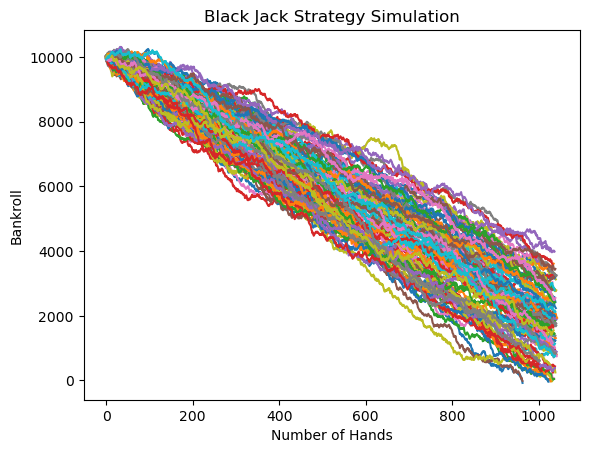

In [8]:
# Define constants
N_SIMS = 100
N_HANDS = 1000
MIN_BET  = 25
INITIAL_BANKROLL = 10000

sims = []

for i in range(0, N_SIMS):
    sims.append(simulate_game(basic_strategy, num_decks=6, num_hands=N_HANDS, penetration_limit=0.25, initial_bankroll=INITIAL_BANKROLL, bet_size=MIN_BET))
plt.title("Black Jack Strategy Simulation")
plt.xlabel("Number of Hands")
plt.ylabel("Bankroll")
plt.show()

In [9]:
def get_simulation_summary(sims: list):
    """ Simulation summary for a given game and strategy.

    Args:
        sims (list): simulation results.

    Returns:
        pd.Series: summary statistics.
    """

    # Get final pnl across simulations
    final_bankroll = []
    final_pnl = []
    for i in sims:
        final_bankroll.append(i.bankroll)
        final_pnl.append(i.profit)
    
    final_bankroll = pd.Series(final_bankroll)
    final_pnl = pd.Series(final_pnl)

    # Get number of bankrupt simulations
    n_ruins = len(final_bankroll.where(final_bankroll<0).dropna())
    pct_ruin = n_ruins / len(final_bankroll)

    # Get expected value of bankroll after "N_HANDS" hands
    bankroll_median = final_bankroll.median()
    bankroll_mean = final_bankroll.mean()

    # Get expected value of strategy after "N_HANDS" hands
    ev_median = final_pnl.median()
    ev_mean = final_pnl.mean()

    # Get expected value per hand
    ev_per_hand_median = ev_median / N_HANDS
    ev_per_hand_mean = ev_mean / N_HANDS


    # Get strategy win rate
    win_rate = sims[3].win_loss_time_series.count(1) / len(sims[3].win_loss_time_series)

    # Get simulation statistics
    simulation_summary = pd.Series({"Number of Hands per Sim" : N_HANDS,
                                    "Number of Sims" : N_SIMS,
                                    "Risk of Ruin" : pct_ruin, 
                                    "EV Median" : ev_median, 
                                    "EV Mean" : ev_mean, 
                                    "EV per Hand Median" : ev_per_hand_median,
                                    "EV per Hand Mean" : ev_per_hand_mean, 
                                    "Expected Bankroll Median" : bankroll_median,
                                    "Expected Bankroll Mean" : bankroll_mean, 
                                    "Win Rate" : win_rate})

    return simulation_summary

# Get sim
get_simulation_summary(sims)

Number of Hands per Sim     1000.000000
Number of Sims               100.000000
Risk of Ruin                   0.050000
EV Median                  -2756.250000
EV Mean                    -2748.250000
EV per Hand Median            -2.756250
EV per Hand Mean              -2.748250
Expected Bankroll Median    1737.500000
Expected Bankroll Mean      1766.250000
Win Rate                       0.392442
dtype: float64